<a href="https://colab.research.google.com/github/hayoungmk/dsc_project/blob/main/ch6/ch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### RNN으로 넷플릭스 주가 예측

#### 데이터 확인

In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CH06.csv")

# 데이터 파일 읽어옴 - 5개 출력
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


#### 학습용 데이터셋 생성

In [ ]:
# 넷플릭스 데이터셋 정의

import numpy as np

from torch.utils.data import Dataset, DataLoader


class Netflix(Dataset):
   def __init__(self):
       # 데이터 읽기
       self.csv = pd.read_csv(
                "/content/drive/MyDrive/Colab Notebooks/data/CH06.csv")

       # 입력 데이터 정규화
       self.data = self.csv.iloc[:, 1:4].values     # 종가를 제외한 데이터
       self.data = self.data / np.max(self.data)    # 0과 1 사이로 정규화

       # 종가 데이터 정규화
       self.label = data["Close"].values
       self.label = self.label / np.max(self.label)



# 사용 가능한 배치 개수를 반환하는 len() 함수

   def __len__(self):
    return len(self.data) - 30    # 사용 가능한 배치 개수


   def __getitem__(self, i):
    data = self.data[i:i+30]    # 입력 데이터 30일치 읽기
    label = self.label[i+30]    # 종가 데이터 30일치 읽기

    return data, label

#### RNN 모델 정의

In [ ]:
# RNN 클래스 정의

import torch
import torch.nn as nn


class RNN(nn.Module):
   def __init__(self):
       super(RNN, self).__init__()

       # RNN층의 정의
       self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5,batch_first=True)

       # 주가를 예측하는 MLP층 정의
       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64, out_features=1)

       self.relu = nn.ReLU() # 활성화 함수 정의



# RNN 모델의 순전파 정의

   def forward(self, x, h0):
       x, hn = self.rnn(x, h0)    # RNN층의 출력

       # MLP층의 입력으로 사용되게 모양 변경
       x = torch.reshape(x, (x.shape[0], -1))

       # MLP층을 이용해 종가 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

#### 모델 학습

In [ ]:
# 모델, 데이터셋 정의

import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)  # 모델의 정의
dataset = Netflix()       # 데이터셋의 정의

In [ ]:
# 데이터로더 정의

loader = DataLoader(dataset, batch_size=32)

In [ ]:
# 최적화 정의

optim = Adam(params=model.parameters(), lr=0.0001)    # 사용할 최적화 설정

In [ ]:

# 학습 루프 정의
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()
        # 초기 은닉 상태
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        # 모델의 예측값
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        # 손실의 계산
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        loss.backward()  # 오차 역전파
        optim.step()  # 최적화 진행
        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")  # 모델 저장


epoch199 loss:0.0006641172803938389: 100%|██████████| 30/30 [00:00<00:00, 148.73it/s]


#### 모델 성능 평가

In [ ]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)       # 초기 은닉 상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())       # 예측값을 리스트에 추가

       # 손실 계산
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))
       # 손실의 평균치 계산
       total_loss += loss/len(loader)

total_loss.item()

0.002216540277004242

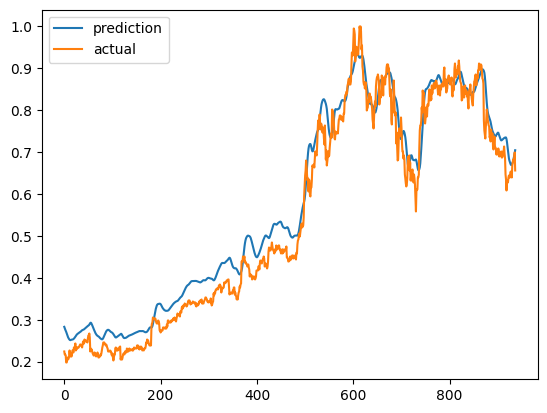

In [ ]:
# 실제 주가와 예측값 변화 및 차이 그래프로 확인

plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()